Based on https://github.com/Hbbbbbby/EmotionRecognition_2Dcnn-lstm. 

In [1]:
import os
import numpy as np
import pandas as pd
import csv
from sklearn import preprocessing
import librosa

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.utils import to_categorical
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

# import own functions
from ipynb.fs.full.Functions import load_train_test_data, model_eval

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = '../data/emodb/wav'

# 2D CNN LSTM

In [3]:
def get_log_mel_spectrogram(path, n_fft=2048, hop_length=512, sample_rate=16000, duration=8, n_mels=128):
    """
    Extract log mel spectrogram with given duration and sample rate.
    """
    y, sr = librosa.load(path, sr=sample_rate, duration=duration)

    file_length = np.size(y)
    
    # pad shorter files & segment longer files than sample rate times duration to ensure same file length
    if file_length < sr * duration: 
        y = np.concatenate((y, np.zeros(int(sr * duration - file_length))), axis=0)
        
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    log_mel_spectrogram = librosa.amplitude_to_db(mel_spectrogram)

    return log_mel_spectrogram

In [4]:
def load_data(path, train_test_val='ours', normalize=True):
    """
    Loads all log mel spectrograms and labels for files in the path.
    returns: Dataframe with file name, log mel spectrogram, label.
    """
    audio_files = os.listdir(path)
    file_dict = {}
    emotion_dict = {'W':'anger', 'L':'boredom', 'E':'disgust', 'A':'fear', 'F':'happiness', 'N':'neutral', 'T':'sadness'}
    file_dict['file'] = []
    file_dict['log_mel_spec'] = []
    file_dict['label'] = []
    for file in audio_files:
        file_dict['file'].append(file)
        log_mel_spec = get_log_mel_spectrogram(path + '/' + file)
        log_mel_spec = log_mel_spec.reshape((-1,))
        file_dict['log_mel_spec'].append(log_mel_spec)
        file_dict['label'].append(emotion_dict[file[5]])
    df = pd.DataFrame.from_dict(file_dict)
    label_enc = preprocessing.LabelEncoder()
    df['label'] = label_enc.fit_transform(df['label'])
    
    # decide whether to normalize the data before splitting
    if normalize:
        X = np.concatenate([np.array(row) for row in df['log_mel_spec']]) # concatenate the data
        X = (X - np.mean(X)) / np.std(X)                                  # normalize based on sklearn StandardScaler (x-u)/s
        X = X.reshape(df.shape[0], df['log_mel_spec'][1].size)            # reshape back
        df['log_mel_spec'] = [row for row in X]                      # write into the correct column
    
    # load train, test, and validation data
    if train_test_val == 'paper':
        # load the train/test data 
        X_train, X_test, y_train, y_test = load_train_test_data(df, test_size = 0.2, verbose=False)

        # split train set into validation and train data (this is not completely clear in the paper, follows github repo)
        df_train = pd.concat([X_train, y_train], axis = 1)
        X_train, X_val, y_train, y_val = load_train_test_data(df_train, test_size=0.2, split_type='train/val', verbose=False)
    
    elif train_test_val == 'ours':
        # load the train/test data 
        X_train, X_test, y_train, y_test = load_train_test_data(df, test_size = 0.3, verbose=False)

        # split test set into validation and test data
        df_test = pd.concat([X_test, y_test], axis = 1)
        X_val, X_test, y_val, y_test = load_train_test_data(df_test, test_size=0.5, split_type='val/test', verbose=False)
    
    print("There are {} entries in the training data.".format(X_train.shape[0]))
    print("There are {} entries in the testing data.".format(X_test.shape[0]))
    print("There are {} entries in the validation data.".format(X_val.shape[0]))
    
    # reshape the data & transform target into categorical ndarray
    X_train = np.concatenate([np.array(row) for row in X_train['log_mel_spec']]).reshape(-1, 128, 251, 1)
    y_train = to_categorical(y_train.values)
    
    X_test = np.concatenate([np.array(row) for row in X_test['log_mel_spec']]).reshape(-1, 128, 251, 1)
    y_test = to_categorical(y_test.values)
    
    X_val = np.concatenate([np.array(row) for row in X_val['log_mel_spec']]).reshape(-1, 128, 251, 1)
    y_val = to_categorical(y_val.values)
     
    return X_train, X_test, X_val, y_train, y_test, y_val

In [5]:
def cnn_lstm_2d(input_shape, num_classes, optimizer_metrics='categorical_accuracy', lstm_size=256):
    
    # set all random seeds
    seed = 0
    keras.utils.set_random_seed(seed)

    model = keras.Sequential(name='cnn_lstm_2d')

    #LFLB1
    model.add(layers.Conv2D(filters=64,
                            kernel_size=3,
                            strides=1,
                            padding='same',
                            input_shape=input_shape
                            )
              )
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('elu'))
    model.add(layers.MaxPooling2D(pool_size=2, strides=2))

    #LFLB2
    model.add(layers.Conv2D(filters=64,
                            kernel_size=3,
                            strides=1,
                            padding='same',
                            )
              )
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('elu'))
    model.add(layers.MaxPooling2D(pool_size=4, strides=4))

    #LFLB3
    model.add(layers.Conv2D(filters=128,
                            kernel_size=3,
                            strides=1,
                            padding='same',
                            )
              )
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('elu'))
    model.add(layers.MaxPooling2D(pool_size=4, strides=4))

    #LFLB4
    model.add(layers.Conv2D(filters=128,
                            kernel_size=3,
                            strides=1,
                            padding='same'
                            )
              )
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('elu'))
    model.add(layers.MaxPooling2D(pool_size=4, strides=4))

    model.add(layers.Reshape((-1, 128)))

    #LSTM
    model.add(layers.LSTM(lstm_size)) ## warum 32? in overview steht was von 256

    model.add(layers.Dense(units=num_classes, activation='softmax'))

    #opt = keras.optimizers.Adam(learning_rate=0.0006, decay=1e-6)
    opt = keras.optimizers.Adam(learning_rate=0.0006)

    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=[optimizer_metrics]
                  )

    return model

In [6]:
def train(X_train, y_train, X_val, y_val, num_epochs, batch_size, model_spec, lstm_size=256, 
          optimizer_metrics='categorical_accuracy', es_monitor='val_loss', patience=10, 
          mc_monitor='val_categorical_accuracy', model_sum=False):
    
    model = cnn_lstm_2d(input_shape=(128, 251, 1), num_classes=7, optimizer_metrics=optimizer_metrics, 
                        lstm_size=lstm_size)
    
    if model_sum:
        model.summary()
        
    es = EarlyStopping(monitor=es_monitor,
                       mode='min',
                       verbose=0,
                       patience=patience)

    mc = ModelCheckpoint('../results/models/{}.h5'.format(model_spec),
                         monitor=mc_monitor,
                         mode='max',
                         verbose=0,
                         save_best_only=True)

    model.fit(X_train, y_train,
              validation_data=(X_val, y_val),
              epochs=num_epochs,
              batch_size=batch_size,
              verbose=2,
              callbacks=[es, mc])

In [7]:
def test(X_test, y_test, model_spec):
    model = load_model('../results/models/{}.h5'.format(model_spec))
    loss, metric = model.evaluate(X_test, y_test, batch_size=1)
    return loss, metric

## Train Test Val Split from paper 
### Data not normalized

In [8]:
# load the data
X_train, X_test, X_val, y_train, y_test, y_val = load_data(data_path, train_test_val='paper', normalize=False)

There are 342 entries in the training data.
There are 107 entries in the testing data.
There are 86 entries in the validation data.


### With LSTM 256

In [16]:
# train the model
train(X_train, y_train, X_val, y_val, num_epochs=25, batch_size=64, model_spec='2D_CNN_LSTM/epochs25_batch64')

Epoch 1/25
6/6 - 29s - loss: 1.8269 - categorical_accuracy: 0.2515 - val_loss: 1.9201 - val_categorical_accuracy: 0.2326 - 29s/epoch - 5s/step
Epoch 2/25
6/6 - 32s - loss: 1.5370 - categorical_accuracy: 0.4678 - val_loss: 2.0428 - val_categorical_accuracy: 0.2674 - 32s/epoch - 5s/step
Epoch 3/25
6/6 - 48s - loss: 1.2672 - categorical_accuracy: 0.5556 - val_loss: 1.5898 - val_categorical_accuracy: 0.3721 - 48s/epoch - 8s/step
Epoch 4/25
6/6 - 36s - loss: 1.0476 - categorical_accuracy: 0.6637 - val_loss: 1.2336 - val_categorical_accuracy: 0.4651 - 36s/epoch - 6s/step
Epoch 5/25
6/6 - 37s - loss: 0.8475 - categorical_accuracy: 0.7368 - val_loss: 1.1414 - val_categorical_accuracy: 0.5814 - 37s/epoch - 6s/step
Epoch 6/25
6/6 - 37s - loss: 0.6874 - categorical_accuracy: 0.8041 - val_loss: 1.1965 - val_categorical_accuracy: 0.5698 - 37s/epoch - 6s/step
Epoch 7/25
6/6 - 37s - loss: 0.5589 - categorical_accuracy: 0.8626 - val_loss: 0.9928 - val_categorical_accuracy: 0.5116 - 37s/epoch - 6s/step

In [17]:
loss, metric = test(X_test, y_test, model_spec='2D_CNN_LSTM/epochs25_batch64')

107/107 [==============================] - 4s 36ms/step - loss: 0.6635 - categorical_accuracy: 0.7664


In [20]:
# train the model
train(X_train, y_train, X_val, y_val, num_epochs=25, batch_size=32, model_spec='2D_CNN_LSTM/epochs25_batch32')

# evaluate model
loss, metric = test(X_test, y_test, model_spec='2D_CNN_LSTM/epochs25_batch32')

Epoch 1/25
11/11 - 26s - loss: 1.7685 - categorical_accuracy: 0.3246 - val_loss: 1.8171 - val_categorical_accuracy: 0.2558 - 26s/epoch - 2s/step
Epoch 2/25
11/11 - 26s - loss: 1.3881 - categorical_accuracy: 0.5146 - val_loss: 1.5064 - val_categorical_accuracy: 0.3953 - 26s/epoch - 2s/step
Epoch 3/25
11/11 - 28s - loss: 1.1166 - categorical_accuracy: 0.5877 - val_loss: 1.1606 - val_categorical_accuracy: 0.5000 - 28s/epoch - 3s/step
Epoch 4/25
11/11 - 28s - loss: 0.8856 - categorical_accuracy: 0.6988 - val_loss: 1.0888 - val_categorical_accuracy: 0.5930 - 28s/epoch - 3s/step
Epoch 5/25
11/11 - 29s - loss: 0.7693 - categorical_accuracy: 0.7368 - val_loss: 1.3276 - val_categorical_accuracy: 0.6163 - 29s/epoch - 3s/step
Epoch 6/25
11/11 - 27s - loss: 0.5755 - categorical_accuracy: 0.8099 - val_loss: 0.9525 - val_categorical_accuracy: 0.5349 - 27s/epoch - 2s/step
Epoch 7/25
11/11 - 28s - loss: 0.4436 - categorical_accuracy: 0.8830 - val_loss: 1.0053 - val_categorical_accuracy: 0.5930 - 28s/e

In [21]:
# train the model
train(X_train, y_train, X_val, y_val, num_epochs=25, batch_size=16, model_spec='2D_CNN_LSTM/epochs25_batch16')

# evaluate model
loss, metric = test(X_test, y_test, model_spec='2D_CNN_LSTM/epochs25_batch16')

Epoch 1/25
22/22 - 33s - loss: 1.7362 - categorical_accuracy: 0.3216 - val_loss: 1.6186 - val_categorical_accuracy: 0.3837 - 33s/epoch - 1s/step
Epoch 2/25
22/22 - 28s - loss: 1.2716 - categorical_accuracy: 0.5351 - val_loss: 1.3573 - val_categorical_accuracy: 0.4535 - 28s/epoch - 1s/step
Epoch 3/25
22/22 - 29s - loss: 1.0724 - categorical_accuracy: 0.5906 - val_loss: 1.0281 - val_categorical_accuracy: 0.6047 - 29s/epoch - 1s/step
Epoch 4/25
22/22 - 28s - loss: 0.9187 - categorical_accuracy: 0.6725 - val_loss: 1.0650 - val_categorical_accuracy: 0.5698 - 28s/epoch - 1s/step
Epoch 5/25
22/22 - 28s - loss: 0.7731 - categorical_accuracy: 0.7135 - val_loss: 0.9534 - val_categorical_accuracy: 0.5465 - 28s/epoch - 1s/step
Epoch 6/25
22/22 - 28s - loss: 0.5719 - categorical_accuracy: 0.8275 - val_loss: 1.2533 - val_categorical_accuracy: 0.5116 - 28s/epoch - 1s/step
Epoch 7/25
22/22 - 28s - loss: 0.4255 - categorical_accuracy: 0.8567 - val_loss: 1.0181 - val_categorical_accuracy: 0.5930 - 28s/e

In [22]:
# train the model
train(X_train, y_train, X_val, y_val, num_epochs=25, batch_size=8, model_spec='2D_CNN_LSTM/epochs25_batch8')

# evaluate model
loss, metric = test(X_test, y_test, model_spec='2D_CNN_LSTM/epochs25_batch8')

Epoch 1/25
43/43 - 32s - loss: 1.7080 - categorical_accuracy: 0.3363 - val_loss: 1.4336 - val_categorical_accuracy: 0.3953 - 32s/epoch - 744ms/step
Epoch 2/25
43/43 - 28s - loss: 1.3117 - categorical_accuracy: 0.5000 - val_loss: 1.1006 - val_categorical_accuracy: 0.5116 - 28s/epoch - 653ms/step
Epoch 3/25
43/43 - 28s - loss: 1.1246 - categorical_accuracy: 0.5146 - val_loss: 1.1987 - val_categorical_accuracy: 0.5116 - 28s/epoch - 643ms/step
Epoch 4/25
43/43 - 28s - loss: 0.9800 - categorical_accuracy: 0.6257 - val_loss: 1.1582 - val_categorical_accuracy: 0.4535 - 28s/epoch - 646ms/step
Epoch 5/25
43/43 - 28s - loss: 0.8487 - categorical_accuracy: 0.6901 - val_loss: 0.8806 - val_categorical_accuracy: 0.6395 - 28s/epoch - 660ms/step
Epoch 6/25
43/43 - 28s - loss: 0.6933 - categorical_accuracy: 0.7573 - val_loss: 0.9234 - val_categorical_accuracy: 0.6047 - 28s/epoch - 646ms/step
Epoch 7/25
43/43 - 28s - loss: 0.4840 - categorical_accuracy: 0.8392 - val_loss: 1.2465 - val_categorical_accura

In [18]:
# train the model
train(X_train, y_train, X_val, y_val, num_epochs=25, batch_size=4, model_spec='2D_CNN_LSTM/epochs25_batch4')

Epoch 1/25
86/86 - 30s - loss: 1.7165 - categorical_accuracy: 0.3333 - val_loss: 1.3899 - val_categorical_accuracy: 0.3953 - 30s/epoch - 351ms/step
Epoch 2/25
86/86 - 24s - loss: 1.4087 - categorical_accuracy: 0.4211 - val_loss: 1.2757 - val_categorical_accuracy: 0.4651 - 24s/epoch - 279ms/step
Epoch 3/25
86/86 - 24s - loss: 1.2392 - categorical_accuracy: 0.4942 - val_loss: 1.1881 - val_categorical_accuracy: 0.5116 - 24s/epoch - 275ms/step
Epoch 4/25
86/86 - 24s - loss: 1.1216 - categorical_accuracy: 0.5292 - val_loss: 1.1114 - val_categorical_accuracy: 0.5233 - 24s/epoch - 278ms/step
Epoch 5/25
86/86 - 24s - loss: 1.0703 - categorical_accuracy: 0.5965 - val_loss: 1.3615 - val_categorical_accuracy: 0.4186 - 24s/epoch - 279ms/step
Epoch 6/25
86/86 - 24s - loss: 0.9057 - categorical_accuracy: 0.6462 - val_loss: 0.9130 - val_categorical_accuracy: 0.5698 - 24s/epoch - 276ms/step
Epoch 7/25
86/86 - 24s - loss: 0.7227 - categorical_accuracy: 0.7485 - val_loss: 0.8457 - val_categorical_accura

In [19]:
loss, metric = test(X_test, y_test, model_spec='2D_CNN_LSTM/epochs25_batch4')

107/107 [==============================] - 4s 27ms/step - loss: 0.6445 - categorical_accuracy: 0.8131


### With LSTM size 32

In [24]:
# train the model
train(X_train, y_train, X_val, y_val, num_epochs=25, batch_size=64, model_spec='2D_CNN_LSTM/epochs25_batch64_LSTM32', lstm_size=32)

# evaluate model
loss, metric = test(X_test, y_test, model_spec='2D_CNN_LSTM/epochs25_batch64_LSTM32')

Epoch 1/25
6/6 - 46s - loss: 1.8948 - categorical_accuracy: 0.2953 - val_loss: 1.8290 - val_categorical_accuracy: 0.2326 - 46s/epoch - 8s/step
Epoch 2/25
6/6 - 38s - loss: 1.6353 - categorical_accuracy: 0.4532 - val_loss: 1.7107 - val_categorical_accuracy: 0.3023 - 38s/epoch - 6s/step
Epoch 3/25
6/6 - 38s - loss: 1.4440 - categorical_accuracy: 0.5643 - val_loss: 1.5610 - val_categorical_accuracy: 0.4302 - 38s/epoch - 6s/step
Epoch 4/25
6/6 - 38s - loss: 1.3213 - categorical_accuracy: 0.6433 - val_loss: 1.5050 - val_categorical_accuracy: 0.4070 - 38s/epoch - 6s/step
Epoch 5/25
6/6 - 39s - loss: 1.1895 - categorical_accuracy: 0.6988 - val_loss: 1.4595 - val_categorical_accuracy: 0.4186 - 39s/epoch - 7s/step
Epoch 6/25
6/6 - 41s - loss: 1.0778 - categorical_accuracy: 0.7456 - val_loss: 1.4149 - val_categorical_accuracy: 0.4884 - 41s/epoch - 7s/step
Epoch 7/25
6/6 - 39s - loss: 0.9646 - categorical_accuracy: 0.7953 - val_loss: 1.3559 - val_categorical_accuracy: 0.4767 - 39s/epoch - 6s/step

In [25]:
# train the model
train(X_train, y_train, X_val, y_val, num_epochs=25, batch_size=32, model_spec='2D_CNN_LSTM/epochs25_batch32_LSTM32', lstm_size=32)

# evaluate model
loss, metric = test(X_test, y_test, model_spec='2D_CNN_LSTM/epochs25_batch32_LSTM32')

Epoch 1/25
11/11 - 37s - loss: 1.8288 - categorical_accuracy: 0.2982 - val_loss: 1.8044 - val_categorical_accuracy: 0.3023 - 37s/epoch - 3s/step
Epoch 2/25
11/11 - 32s - loss: 1.5230 - categorical_accuracy: 0.5000 - val_loss: 1.5849 - val_categorical_accuracy: 0.4070 - 32s/epoch - 3s/step
Epoch 3/25
11/11 - 32s - loss: 1.3430 - categorical_accuracy: 0.5965 - val_loss: 1.5058 - val_categorical_accuracy: 0.3953 - 32s/epoch - 3s/step
Epoch 4/25
11/11 - 32s - loss: 1.2033 - categorical_accuracy: 0.6433 - val_loss: 1.3240 - val_categorical_accuracy: 0.5116 - 32s/epoch - 3s/step
Epoch 5/25
11/11 - 33s - loss: 1.0459 - categorical_accuracy: 0.7368 - val_loss: 1.2086 - val_categorical_accuracy: 0.5698 - 33s/epoch - 3s/step
Epoch 6/25
11/11 - 33s - loss: 0.9017 - categorical_accuracy: 0.8041 - val_loss: 1.2949 - val_categorical_accuracy: 0.4767 - 33s/epoch - 3s/step
Epoch 7/25
11/11 - 32s - loss: 0.7670 - categorical_accuracy: 0.8567 - val_loss: 1.1650 - val_categorical_accuracy: 0.5000 - 32s/e

In [26]:
# train the model
train(X_train, y_train, X_val, y_val, num_epochs=25, batch_size=16, model_spec='2D_CNN_LSTM/epochs25_batch16_LSTM32', lstm_size=32 )

# evaluate model
loss, metric = test(X_test, y_test, model_spec='2D_CNN_LSTM/epochs25_batch16_LSTM32')

Epoch 1/25
22/22 - 42s - loss: 1.7906 - categorical_accuracy: 0.3099 - val_loss: 1.7044 - val_categorical_accuracy: 0.3256 - 42s/epoch - 2s/step
Epoch 2/25
22/22 - 35s - loss: 1.4803 - categorical_accuracy: 0.5146 - val_loss: 1.5257 - val_categorical_accuracy: 0.3721 - 35s/epoch - 2s/step
Epoch 3/25
22/22 - 35s - loss: 1.2972 - categorical_accuracy: 0.5673 - val_loss: 1.4207 - val_categorical_accuracy: 0.4535 - 35s/epoch - 2s/step
Epoch 4/25
22/22 - 35s - loss: 1.1885 - categorical_accuracy: 0.6023 - val_loss: 1.4520 - val_categorical_accuracy: 0.4419 - 35s/epoch - 2s/step
Epoch 5/25
22/22 - 36s - loss: 0.9909 - categorical_accuracy: 0.6959 - val_loss: 1.2740 - val_categorical_accuracy: 0.5233 - 36s/epoch - 2s/step
Epoch 6/25
22/22 - 35s - loss: 0.8826 - categorical_accuracy: 0.7456 - val_loss: 1.2318 - val_categorical_accuracy: 0.5581 - 35s/epoch - 2s/step
Epoch 7/25
22/22 - 36s - loss: 0.7594 - categorical_accuracy: 0.7953 - val_loss: 1.1104 - val_categorical_accuracy: 0.5581 - 36s/e

In [27]:
# train the model
train(X_train, y_train, X_val, y_val, num_epochs=25, batch_size=8, model_spec='2D_CNN_LSTM/epochs25_batch8_LSTM32', lstm_size=32)

# evaluate model
loss, metric = test(X_test, y_test, model_spec='2D_CNN_LSTM/epochs25_batch8_LSTM32')

Epoch 1/25
43/43 - 34s - loss: 1.7367 - categorical_accuracy: 0.3480 - val_loss: 1.5068 - val_categorical_accuracy: 0.3837 - 34s/epoch - 793ms/step
Epoch 2/25
43/43 - 27s - loss: 1.4366 - categorical_accuracy: 0.4795 - val_loss: 1.3221 - val_categorical_accuracy: 0.5814 - 27s/epoch - 630ms/step
Epoch 3/25
43/43 - 27s - loss: 1.2189 - categorical_accuracy: 0.5848 - val_loss: 1.3651 - val_categorical_accuracy: 0.4419 - 27s/epoch - 633ms/step
Epoch 4/25
43/43 - 28s - loss: 1.1421 - categorical_accuracy: 0.5994 - val_loss: 1.2236 - val_categorical_accuracy: 0.5814 - 28s/epoch - 643ms/step
Epoch 5/25
43/43 - 27s - loss: 1.0236 - categorical_accuracy: 0.6491 - val_loss: 1.0195 - val_categorical_accuracy: 0.6279 - 27s/epoch - 635ms/step
Epoch 6/25
43/43 - 27s - loss: 0.9322 - categorical_accuracy: 0.6725 - val_loss: 1.0125 - val_categorical_accuracy: 0.5814 - 27s/epoch - 637ms/step
Epoch 7/25
43/43 - 27s - loss: 0.7772 - categorical_accuracy: 0.7719 - val_loss: 0.9661 - val_categorical_accura

In [28]:
# train the model
train(X_train, y_train, X_val, y_val, num_epochs=25, batch_size=4, model_spec='2D_CNN_LSTM/epochs25_batch4_LSTM32', lstm_size=32)

# evaluate model
loss, metric = test(X_test, y_test, model_spec='2D_CNN_LSTM/epochs25_batch4_LSTM32')

Epoch 1/25
86/86 - 47s - loss: 1.7588 - categorical_accuracy: 0.3275 - val_loss: 1.5719 - val_categorical_accuracy: 0.3721 - 47s/epoch - 545ms/step
Epoch 2/25
86/86 - 41s - loss: 1.5278 - categorical_accuracy: 0.4503 - val_loss: 1.3439 - val_categorical_accuracy: 0.4884 - 41s/epoch - 476ms/step
Epoch 3/25
86/86 - 43s - loss: 1.3527 - categorical_accuracy: 0.4942 - val_loss: 1.2300 - val_categorical_accuracy: 0.4884 - 43s/epoch - 500ms/step
Epoch 4/25
86/86 - 41s - loss: 1.2281 - categorical_accuracy: 0.5146 - val_loss: 1.2913 - val_categorical_accuracy: 0.5000 - 41s/epoch - 473ms/step
Epoch 5/25
86/86 - 41s - loss: 1.1392 - categorical_accuracy: 0.5819 - val_loss: 1.3613 - val_categorical_accuracy: 0.4767 - 41s/epoch - 481ms/step
Epoch 6/25
86/86 - 41s - loss: 1.0443 - categorical_accuracy: 0.6637 - val_loss: 1.0155 - val_categorical_accuracy: 0.6279 - 41s/epoch - 475ms/step
Epoch 7/25
86/86 - 41s - loss: 0.8872 - categorical_accuracy: 0.6930 - val_loss: 1.0409 - val_categorical_accura

### Data normalized

In [32]:
# load the data
X_train, X_test, X_val, y_train, y_test, y_val = load_data(data_path, train_test_val='paper', normalize=True)

There are 342 entries in the training data.
There are 107 entries in the testing data.
There are 86 entries in the validation data.


In [36]:
# train the model
train(X_train, y_train, X_val, y_val, num_epochs=25, batch_size=4, model_spec='2D_CNN_LSTM/epochs25_batch4_datanorm')

# evaluate model
loss, metric = test(X_test, y_test, model_spec='2D_CNN_LSTM/epochs25_batch4_datanorm')

Epoch 1/25
86/86 - 38s - loss: 1.7255 - categorical_accuracy: 0.3275 - val_loss: 1.6588 - val_categorical_accuracy: 0.4884 - 38s/epoch - 438ms/step
Epoch 2/25
86/86 - 34s - loss: 1.4146 - categorical_accuracy: 0.4269 - val_loss: 1.3739 - val_categorical_accuracy: 0.5000 - 34s/epoch - 395ms/step
Epoch 3/25
86/86 - 34s - loss: 1.2491 - categorical_accuracy: 0.4795 - val_loss: 1.2967 - val_categorical_accuracy: 0.5000 - 34s/epoch - 390ms/step
Epoch 4/25
86/86 - 34s - loss: 1.1090 - categorical_accuracy: 0.5497 - val_loss: 1.3065 - val_categorical_accuracy: 0.4070 - 34s/epoch - 390ms/step
Epoch 5/25
86/86 - 42s - loss: 1.0455 - categorical_accuracy: 0.5731 - val_loss: 1.3285 - val_categorical_accuracy: 0.4302 - 42s/epoch - 494ms/step
Epoch 6/25
86/86 - 39s - loss: 0.9153 - categorical_accuracy: 0.6550 - val_loss: 0.9263 - val_categorical_accuracy: 0.5930 - 39s/epoch - 449ms/step
Epoch 7/25
86/86 - 33s - loss: 0.7150 - categorical_accuracy: 0.7485 - val_loss: 1.2127 - val_categorical_accura

In [37]:
# train the model
train(X_train, y_train, X_val, y_val, num_epochs=25, batch_size=8, model_spec='2D_CNN_LSTM/epochs25_batch8_LSTM32_datanorm', lstm_size=32)

# evaluate model
loss, metric = test(X_test, y_test, model_spec='2D_CNN_LSTM/epochs25_batch8_LSTM32_datanorm')

Epoch 1/25
43/43 - 42s - loss: 1.7444 - categorical_accuracy: 0.3333 - val_loss: 1.7790 - val_categorical_accuracy: 0.4651 - 42s/epoch - 969ms/step
Epoch 2/25
43/43 - 36s - loss: 1.4409 - categorical_accuracy: 0.4912 - val_loss: 1.6775 - val_categorical_accuracy: 0.2791 - 36s/epoch - 844ms/step
Epoch 3/25
43/43 - 37s - loss: 1.2631 - categorical_accuracy: 0.5702 - val_loss: 1.7337 - val_categorical_accuracy: 0.3372 - 37s/epoch - 854ms/step
Epoch 4/25
43/43 - 37s - loss: 1.2144 - categorical_accuracy: 0.5994 - val_loss: 1.6194 - val_categorical_accuracy: 0.2791 - 37s/epoch - 851ms/step
Epoch 5/25
43/43 - 36s - loss: 1.0628 - categorical_accuracy: 0.6520 - val_loss: 1.4937 - val_categorical_accuracy: 0.4535 - 36s/epoch - 842ms/step
Epoch 6/25
43/43 - 36s - loss: 0.9687 - categorical_accuracy: 0.7076 - val_loss: 1.6578 - val_categorical_accuracy: 0.3605 - 36s/epoch - 843ms/step
Epoch 7/25
43/43 - 36s - loss: 0.8227 - categorical_accuracy: 0.7456 - val_loss: 1.4534 - val_categorical_accura

In [38]:
for batch_size in [64,32,16,8,4]:
    for lstm_size in [256,32]:
        
        #print(f'batch_size: {batch_size}, lstm_size:{lstm_size}')
        
        # train the model
        train(X_train, y_train, X_val, y_val, num_epochs=25, batch_size=batch_size, lstm_size=lstm_size, 
              model_spec='2D_CNN_LSTM/epochs25_batch{}_LSTM{}_datanorm'.format(batch_size, lstm_size))

        # evaluate model
        loss, metric = test(X_test, y_test, model_spec='2D_CNN_LSTM/epochs25_batch{}_LSTM{}_datanorm'.format(batch_size, lstm_size))

Epoch 1/25
6/6 - 23s - loss: 1.8268 - categorical_accuracy: 0.2456 - val_loss: 1.8832 - val_categorical_accuracy: 0.2907 - 23s/epoch - 4s/step
Epoch 2/25
6/6 - 22s - loss: 1.5283 - categorical_accuracy: 0.4532 - val_loss: 1.8172 - val_categorical_accuracy: 0.3837 - 22s/epoch - 4s/step
Epoch 3/25
6/6 - 18s - loss: 1.2581 - categorical_accuracy: 0.5614 - val_loss: 1.7523 - val_categorical_accuracy: 0.4884 - 18s/epoch - 3s/step
Epoch 4/25
6/6 - 17s - loss: 1.0499 - categorical_accuracy: 0.6491 - val_loss: 1.7069 - val_categorical_accuracy: 0.4884 - 17s/epoch - 3s/step
Epoch 5/25
6/6 - 17s - loss: 0.8383 - categorical_accuracy: 0.7281 - val_loss: 1.6876 - val_categorical_accuracy: 0.5116 - 17s/epoch - 3s/step
Epoch 6/25
6/6 - 18s - loss: 0.6839 - categorical_accuracy: 0.7953 - val_loss: 1.6863 - val_categorical_accuracy: 0.5581 - 18s/epoch - 3s/step
Epoch 7/25
6/6 - 22s - loss: 0.5513 - categorical_accuracy: 0.8567 - val_loss: 1.6773 - val_categorical_accuracy: 0.3953 - 22s/epoch - 4s/step

Epoch 17/25
11/11 - 29s - loss: 0.0069 - categorical_accuracy: 1.0000 - val_loss: 1.2154 - val_categorical_accuracy: 0.5814 - 29s/epoch - 3s/step
Epoch 18/25
11/11 - 28s - loss: 0.0054 - categorical_accuracy: 1.0000 - val_loss: 1.2005 - val_categorical_accuracy: 0.5698 - 28s/epoch - 3s/step
Epoch 19/25
11/11 - 29s - loss: 0.0043 - categorical_accuracy: 1.0000 - val_loss: 1.1686 - val_categorical_accuracy: 0.5698 - 29s/epoch - 3s/step
Epoch 20/25
11/11 - 29s - loss: 0.0043 - categorical_accuracy: 1.0000 - val_loss: 1.1156 - val_categorical_accuracy: 0.6047 - 29s/epoch - 3s/step
Epoch 21/25
11/11 - 29s - loss: 0.0037 - categorical_accuracy: 1.0000 - val_loss: 1.0631 - val_categorical_accuracy: 0.6163 - 29s/epoch - 3s/step
Epoch 22/25
11/11 - 28s - loss: 0.0036 - categorical_accuracy: 1.0000 - val_loss: 1.0303 - val_categorical_accuracy: 0.6163 - 28s/epoch - 3s/step
Epoch 23/25
11/11 - 29s - loss: 0.0029 - categorical_accuracy: 1.0000 - val_loss: 0.9975 - val_categorical_accuracy: 0.6512 

Epoch 22/25
22/22 - 30s - loss: 0.0037 - categorical_accuracy: 1.0000 - val_loss: 0.6288 - val_categorical_accuracy: 0.7907 - 30s/epoch - 1s/step
Epoch 23/25
22/22 - 29s - loss: 0.0027 - categorical_accuracy: 1.0000 - val_loss: 0.6438 - val_categorical_accuracy: 0.7791 - 29s/epoch - 1s/step
Epoch 24/25
22/22 - 28s - loss: 0.0020 - categorical_accuracy: 1.0000 - val_loss: 0.6605 - val_categorical_accuracy: 0.7791 - 28s/epoch - 1s/step
Epoch 25/25
22/22 - 29s - loss: 0.0028 - categorical_accuracy: 1.0000 - val_loss: 0.6656 - val_categorical_accuracy: 0.8140 - 29s/epoch - 1s/step
107/107 [==============================] - 5s 35ms/step - loss: 0.5739 - categorical_accuracy: 0.7850
Epoch 1/25
22/22 - 34s - loss: 1.7960 - categorical_accuracy: 0.3129 - val_loss: 1.8185 - val_categorical_accuracy: 0.2674 - 34s/epoch - 2s/step
Epoch 2/25
22/22 - 31s - loss: 1.4839 - categorical_accuracy: 0.5000 - val_loss: 1.7378 - val_categorical_accuracy: 0.2558 - 31s/epoch - 1s/step
Epoch 3/25
22/22 - 31s -

86/86 - 33s - loss: 1.2482 - categorical_accuracy: 0.5322 - val_loss: 1.3173 - val_categorical_accuracy: 0.5465 - 33s/epoch - 381ms/step
Epoch 5/25
86/86 - 33s - loss: 1.1700 - categorical_accuracy: 0.5702 - val_loss: 1.2256 - val_categorical_accuracy: 0.4884 - 33s/epoch - 383ms/step
Epoch 6/25
86/86 - 33s - loss: 1.0941 - categorical_accuracy: 0.5877 - val_loss: 1.2061 - val_categorical_accuracy: 0.5233 - 33s/epoch - 383ms/step
Epoch 7/25
86/86 - 33s - loss: 0.9416 - categorical_accuracy: 0.6871 - val_loss: 0.9883 - val_categorical_accuracy: 0.6977 - 33s/epoch - 385ms/step
Epoch 8/25
86/86 - 33s - loss: 0.8748 - categorical_accuracy: 0.7135 - val_loss: 0.9842 - val_categorical_accuracy: 0.6628 - 33s/epoch - 380ms/step
Epoch 9/25
86/86 - 34s - loss: 0.8329 - categorical_accuracy: 0.7339 - val_loss: 1.1429 - val_categorical_accuracy: 0.5000 - 34s/epoch - 394ms/step
Epoch 10/25
86/86 - 33s - loss: 0.7633 - categorical_accuracy: 0.7661 - val_loss: 0.8515 - val_categorical_accuracy: 0.6628

## Own Train Test Val Split
### Data not normalized

In [42]:
# load the data
X_train, X_test, X_val, y_train, y_test, y_val = load_data(data_path, train_test_val='ours', normalize=False)

There are 374 entries in the training data.
There are 81 entries in the testing data.
There are 80 entries in the validation data.


In [54]:
# run different settings
csv_file = '../results/models/2D_CNN_LSTM/ownsplit.csv'

with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Dataset', 'train-test-val', 'LSTM size', 'Epochs', 'Batch size', 'Training', 'Test accuracy', 
                     'Loss', 'F1 macro train', 'F1 macro test'])

for batch_size in [64,32,16,8,4]:
    for lstm_size in [256,32]:
        
        print(f'batch_size: {batch_size}, lstm_size:{lstm_size}')
        
        # train the model
        train(X_train, y_train, X_val, y_val, num_epochs=25, batch_size=batch_size, lstm_size=lstm_size, 
              model_spec='2D_CNN_LSTM/epochs25_batch{}_LSTM{}_datanorm'.format(batch_size, lstm_size))

        # evaluate model
        loss, metric = test(X_test, y_test, model_spec='2D_CNN_LSTM/epochs25_batch{}_LSTM{}_datanorm'.format(batch_size,
                                                                                                             lstm_size))
        
        # store the combination and performance in the results list
        loss = str(loss).replace('.', ',')
        metric = str(metric).replace('.', ',')
        result = ['normalized', '70-15-15', lstm_size, 25, batch_size, 'val loss', metric, loss, None, None]
        
        # write the result to the csv file
        writer.writerow(result)

batch_size: 64, lstm_size:256
Epoch 1/25
6/6 - 30s - loss: 1.7977 - categorical_accuracy: 0.2995 - val_loss: 1.8406 - val_categorical_accuracy: 0.2375 - 30s/epoch - 5s/step
Epoch 2/25
6/6 - 27s - loss: 1.5005 - categorical_accuracy: 0.5107 - val_loss: 1.6382 - val_categorical_accuracy: 0.2625 - 27s/epoch - 4s/step
Epoch 3/25
6/6 - 30s - loss: 1.2335 - categorical_accuracy: 0.5829 - val_loss: 1.2827 - val_categorical_accuracy: 0.5250 - 30s/epoch - 5s/step
Epoch 4/25
6/6 - 42s - loss: 0.9735 - categorical_accuracy: 0.6604 - val_loss: 1.1188 - val_categorical_accuracy: 0.5625 - 42s/epoch - 7s/step
Epoch 5/25
6/6 - 50s - loss: 0.8002 - categorical_accuracy: 0.7487 - val_loss: 0.9499 - val_categorical_accuracy: 0.6125 - 50s/epoch - 8s/step
Epoch 6/25
6/6 - 45s - loss: 0.6485 - categorical_accuracy: 0.8021 - val_loss: 0.9486 - val_categorical_accuracy: 0.6375 - 45s/epoch - 8s/step
Epoch 7/25
6/6 - 45s - loss: 0.4966 - categorical_accuracy: 0.8743 - val_loss: 0.7738 - val_categorical_accuracy

Epoch 6/25
12/12 - 35s - loss: 0.6222 - categorical_accuracy: 0.7781 - val_loss: 1.0183 - val_categorical_accuracy: 0.5750 - 35s/epoch - 3s/step
Epoch 7/25
12/12 - 53s - loss: 0.5504 - categorical_accuracy: 0.7968 - val_loss: 0.7052 - val_categorical_accuracy: 0.7500 - 53s/epoch - 4s/step
Epoch 8/25
12/12 - 56s - loss: 0.3658 - categorical_accuracy: 0.8984 - val_loss: 0.7317 - val_categorical_accuracy: 0.7000 - 56s/epoch - 5s/step
Epoch 9/25
12/12 - 54s - loss: 0.2322 - categorical_accuracy: 0.9599 - val_loss: 0.6385 - val_categorical_accuracy: 0.7375 - 54s/epoch - 4s/step
Epoch 10/25
12/12 - 55s - loss: 0.1344 - categorical_accuracy: 0.9893 - val_loss: 0.8021 - val_categorical_accuracy: 0.6875 - 55s/epoch - 5s/step
Epoch 11/25
12/12 - 55s - loss: 0.1003 - categorical_accuracy: 0.9866 - val_loss: 0.6664 - val_categorical_accuracy: 0.7500 - 55s/epoch - 5s/step
Epoch 12/25
12/12 - 53s - loss: 0.0608 - categorical_accuracy: 1.0000 - val_loss: 0.6085 - val_categorical_accuracy: 0.8000 - 53

Epoch 11/25
24/24 - 39s - loss: 0.2276 - categorical_accuracy: 0.9278 - val_loss: 0.5059 - val_categorical_accuracy: 0.7750 - 39s/epoch - 2s/step
Epoch 12/25
24/24 - 36s - loss: 0.0749 - categorical_accuracy: 0.9920 - val_loss: 0.6566 - val_categorical_accuracy: 0.8000 - 36s/epoch - 1s/step
Epoch 13/25
24/24 - 37s - loss: 0.1313 - categorical_accuracy: 0.9652 - val_loss: 0.9836 - val_categorical_accuracy: 0.6250 - 37s/epoch - 2s/step
Epoch 14/25
24/24 - 38s - loss: 0.0428 - categorical_accuracy: 0.9973 - val_loss: 0.7232 - val_categorical_accuracy: 0.7500 - 38s/epoch - 2s/step
Epoch 15/25
24/24 - 38s - loss: 0.0159 - categorical_accuracy: 1.0000 - val_loss: 0.4796 - val_categorical_accuracy: 0.8125 - 38s/epoch - 2s/step
Epoch 16/25
24/24 - 38s - loss: 0.0103 - categorical_accuracy: 1.0000 - val_loss: 0.6588 - val_categorical_accuracy: 0.7750 - 38s/epoch - 2s/step
Epoch 17/25
24/24 - 39s - loss: 0.0090 - categorical_accuracy: 1.0000 - val_loss: 0.5077 - val_categorical_accuracy: 0.7750 

Epoch 16/25
47/47 - 54s - loss: 0.0104 - categorical_accuracy: 1.0000 - val_loss: 0.4635 - val_categorical_accuracy: 0.7875 - 54s/epoch - 1s/step
Epoch 17/25
47/47 - 50s - loss: 0.0064 - categorical_accuracy: 1.0000 - val_loss: 0.4391 - val_categorical_accuracy: 0.8250 - 50s/epoch - 1s/step
Epoch 18/25
47/47 - 40s - loss: 0.0047 - categorical_accuracy: 1.0000 - val_loss: 0.4168 - val_categorical_accuracy: 0.8375 - 40s/epoch - 848ms/step
Epoch 19/25
47/47 - 38s - loss: 0.0039 - categorical_accuracy: 1.0000 - val_loss: 0.4278 - val_categorical_accuracy: 0.8375 - 38s/epoch - 813ms/step
Epoch 20/25
47/47 - 39s - loss: 0.0030 - categorical_accuracy: 1.0000 - val_loss: 0.4114 - val_categorical_accuracy: 0.8125 - 39s/epoch - 819ms/step
Epoch 21/25
47/47 - 37s - loss: 0.0023 - categorical_accuracy: 1.0000 - val_loss: 0.4123 - val_categorical_accuracy: 0.8375 - 37s/epoch - 783ms/step
Epoch 22/25
47/47 - 41s - loss: 0.0031 - categorical_accuracy: 1.0000 - val_loss: 0.4186 - val_categorical_accur

Epoch 20/25
94/94 - 32s - loss: 0.1255 - categorical_accuracy: 0.9572 - val_loss: 0.8908 - val_categorical_accuracy: 0.7500 - 32s/epoch - 339ms/step
Epoch 21/25
94/94 - 31s - loss: 0.0696 - categorical_accuracy: 0.9813 - val_loss: 0.5311 - val_categorical_accuracy: 0.8125 - 31s/epoch - 334ms/step
Epoch 22/25
94/94 - 32s - loss: 0.0156 - categorical_accuracy: 0.9973 - val_loss: 0.5890 - val_categorical_accuracy: 0.8250 - 32s/epoch - 338ms/step
Epoch 23/25
94/94 - 31s - loss: 0.0084 - categorical_accuracy: 1.0000 - val_loss: 0.5915 - val_categorical_accuracy: 0.8250 - 31s/epoch - 332ms/step
81/81 [==============================] - 3s 25ms/step - loss: 0.8820 - categorical_accuracy: 0.7037
batch_size: 4, lstm_size:32
Epoch 1/25
94/94 - 44s - loss: 1.6774 - categorical_accuracy: 0.3610 - val_loss: 1.5912 - val_categorical_accuracy: 0.3000 - 44s/epoch - 464ms/step
Epoch 2/25
94/94 - 37s - loss: 1.4761 - categorical_accuracy: 0.4679 - val_loss: 1.3315 - val_categorical_accuracy: 0.5250 - 37s

### Data normalized

In [55]:
# load the data
X_train, X_test, X_val, y_train, y_test, y_val = load_data(data_path, train_test_val='ours', normalize=True)

There are 374 entries in the training data.
There are 81 entries in the testing data.
There are 80 entries in the validation data.


In [56]:
# run different settings
csv_file = '../results/models/2D_CNN_LSTM/ownsplit_datanorm.csv'

with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Dataset', 'train-test-val', 'LSTM size', 'Epochs', 'Batch size', 'Training', 'Test accuracy', 
                     'Loss', 'F1 macro train', 'F1 macro test'])

for batch_size in [64,32,16,8,4]:
    for lstm_size in [256,32]:
        
        print(f'batch_size: {batch_size}, lstm_size:{lstm_size}')
        
        # train the model
        train(X_train, y_train, X_val, y_val, num_epochs=25, batch_size=batch_size, lstm_size=lstm_size, 
              model_spec='2D_CNN_LSTM/epochs25_batch{}_LSTM{}_datanorm'.format(batch_size, lstm_size))

        # evaluate model
        loss, metric = test(X_test, y_test, model_spec='2D_CNN_LSTM/epochs25_batch{}_LSTM{}_datanorm'.format(batch_size,
                                                                                                             lstm_size))
        
        # store the combination and performance in the results list
        loss = str(loss).replace('.', ',')
        metric = str(metric).replace('.', ',')
        result = ['normalized', '70-15-15', lstm_size, 25, batch_size, 'val loss', metric, loss, None, None]
        
        # write the result to the csv file
        writer.writerow(result)

batch_size: 64, lstm_size:256
Epoch 1/25
6/6 - 37s - loss: 1.7896 - categorical_accuracy: 0.3021 - val_loss: 1.8677 - val_categorical_accuracy: 0.4500 - 37s/epoch - 6s/step
Epoch 2/25
6/6 - 33s - loss: 1.4833 - categorical_accuracy: 0.5294 - val_loss: 1.8068 - val_categorical_accuracy: 0.5375 - 33s/epoch - 5s/step
Epoch 3/25
6/6 - 33s - loss: 1.2037 - categorical_accuracy: 0.5882 - val_loss: 1.7282 - val_categorical_accuracy: 0.5875 - 33s/epoch - 5s/step
Epoch 4/25
6/6 - 34s - loss: 0.9387 - categorical_accuracy: 0.6925 - val_loss: 1.6818 - val_categorical_accuracy: 0.4750 - 34s/epoch - 6s/step
Epoch 5/25
6/6 - 34s - loss: 0.7698 - categorical_accuracy: 0.7513 - val_loss: 1.6521 - val_categorical_accuracy: 0.4625 - 34s/epoch - 6s/step
Epoch 6/25
6/6 - 34s - loss: 0.6210 - categorical_accuracy: 0.8102 - val_loss: 1.6514 - val_categorical_accuracy: 0.4625 - 34s/epoch - 6s/step
Epoch 7/25
6/6 - 33s - loss: 0.4852 - categorical_accuracy: 0.8717 - val_loss: 1.5998 - val_categorical_accuracy

Epoch 24/25
12/12 - 45s - loss: 0.0031 - categorical_accuracy: 1.0000 - val_loss: 1.1447 - val_categorical_accuracy: 0.5750 - 45s/epoch - 4s/step
Epoch 25/25
12/12 - 51s - loss: 0.0024 - categorical_accuracy: 1.0000 - val_loss: 1.0405 - val_categorical_accuracy: 0.6000 - 51s/epoch - 4s/step
81/81 [==============================] - 5s 55ms/step - loss: 1.2784 - categorical_accuracy: 0.5556
batch_size: 32, lstm_size:32
Epoch 1/25
12/12 - 45s - loss: 1.7802 - categorical_accuracy: 0.3235 - val_loss: 1.8183 - val_categorical_accuracy: 0.4125 - 45s/epoch - 4s/step
Epoch 2/25
12/12 - 45s - loss: 1.4927 - categorical_accuracy: 0.5214 - val_loss: 1.7246 - val_categorical_accuracy: 0.4875 - 45s/epoch - 4s/step
Epoch 3/25
12/12 - 39s - loss: 1.3162 - categorical_accuracy: 0.6070 - val_loss: 1.6875 - val_categorical_accuracy: 0.3875 - 39s/epoch - 3s/step
Epoch 4/25
12/12 - 41s - loss: 1.1659 - categorical_accuracy: 0.6524 - val_loss: 1.7205 - val_categorical_accuracy: 0.3750 - 41s/epoch - 3s/step

Epoch 15/25
24/24 - 40s - loss: 0.1315 - categorical_accuracy: 1.0000 - val_loss: 1.0185 - val_categorical_accuracy: 0.5750 - 40s/epoch - 2s/step
Epoch 16/25
24/24 - 39s - loss: 0.1073 - categorical_accuracy: 1.0000 - val_loss: 0.9336 - val_categorical_accuracy: 0.6375 - 39s/epoch - 2s/step
Epoch 17/25
24/24 - 40s - loss: 0.0950 - categorical_accuracy: 1.0000 - val_loss: 0.9090 - val_categorical_accuracy: 0.6500 - 40s/epoch - 2s/step
Epoch 18/25
24/24 - 40s - loss: 0.0810 - categorical_accuracy: 1.0000 - val_loss: 0.8231 - val_categorical_accuracy: 0.7125 - 40s/epoch - 2s/step
Epoch 19/25
24/24 - 40s - loss: 0.0717 - categorical_accuracy: 1.0000 - val_loss: 0.7362 - val_categorical_accuracy: 0.7375 - 40s/epoch - 2s/step
Epoch 20/25
24/24 - 40s - loss: 0.0622 - categorical_accuracy: 1.0000 - val_loss: 0.6513 - val_categorical_accuracy: 0.7750 - 40s/epoch - 2s/step
Epoch 21/25
24/24 - 41s - loss: 0.0575 - categorical_accuracy: 1.0000 - val_loss: 0.6283 - val_categorical_accuracy: 0.8000 

Epoch 19/25
47/47 - 35s - loss: 0.0747 - categorical_accuracy: 1.0000 - val_loss: 0.5154 - val_categorical_accuracy: 0.8375 - 35s/epoch - 740ms/step
Epoch 20/25
47/47 - 35s - loss: 0.0609 - categorical_accuracy: 1.0000 - val_loss: 0.4902 - val_categorical_accuracy: 0.8500 - 35s/epoch - 745ms/step
Epoch 21/25
47/47 - 33s - loss: 0.0523 - categorical_accuracy: 1.0000 - val_loss: 0.4556 - val_categorical_accuracy: 0.8625 - 33s/epoch - 712ms/step
Epoch 22/25
47/47 - 32s - loss: 0.0454 - categorical_accuracy: 1.0000 - val_loss: 0.4688 - val_categorical_accuracy: 0.8625 - 32s/epoch - 681ms/step
Epoch 23/25
47/47 - 32s - loss: 0.0404 - categorical_accuracy: 1.0000 - val_loss: 0.4581 - val_categorical_accuracy: 0.8500 - 32s/epoch - 683ms/step
Epoch 24/25
47/47 - 32s - loss: 0.0372 - categorical_accuracy: 1.0000 - val_loss: 0.4801 - val_categorical_accuracy: 0.8375 - 32s/epoch - 676ms/step
Epoch 25/25
47/47 - 32s - loss: 0.0331 - categorical_accuracy: 1.0000 - val_loss: 0.4620 - val_categorical

Epoch 23/25
94/94 - 31s - loss: 0.0361 - categorical_accuracy: 1.0000 - val_loss: 0.5980 - val_categorical_accuracy: 0.7875 - 31s/epoch - 333ms/step
Epoch 24/25
94/94 - 31s - loss: 0.0324 - categorical_accuracy: 1.0000 - val_loss: 0.4997 - val_categorical_accuracy: 0.8625 - 31s/epoch - 327ms/step
Epoch 25/25
94/94 - 31s - loss: 0.0280 - categorical_accuracy: 1.0000 - val_loss: 0.4823 - val_categorical_accuracy: 0.8375 - 31s/epoch - 325ms/step
81/81 [==============================] - 3s 27ms/step - loss: 0.5843 - categorical_accuracy: 0.7901


### With different optimization metrics

# Best Models 
## Run best models so far for more epochs
### 1) Normal data, paper split, LSTM size 32, batch size 8

There are 342 entries in the training data.
There are 107 entries in the testing data.
There are 86 entries in the validation data.
Epoch 1/100
43/43 - 22s - loss: 1.7367 - categorical_accuracy: 0.3480 - val_loss: 1.5068 - val_categorical_accuracy: 0.3837 - 22s/epoch - 503ms/step
Epoch 2/100
43/43 - 16s - loss: 1.4366 - categorical_accuracy: 0.4795 - val_loss: 1.3221 - val_categorical_accuracy: 0.5814 - 16s/epoch - 372ms/step
Epoch 3/100
43/43 - 16s - loss: 1.2189 - categorical_accuracy: 0.5848 - val_loss: 1.3651 - val_categorical_accuracy: 0.4419 - 16s/epoch - 375ms/step
Epoch 4/100
43/43 - 18s - loss: 1.1421 - categorical_accuracy: 0.5994 - val_loss: 1.2236 - val_categorical_accuracy: 0.5814 - 18s/epoch - 416ms/step
Epoch 5/100
43/43 - 24s - loss: 1.0236 - categorical_accuracy: 0.6491 - val_loss: 1.0195 - val_categorical_accuracy: 0.6279 - 24s/epoch - 565ms/step
Epoch 6/100
43/43 - 30s - loss: 0.9322 - categorical_accuracy: 0.6725 - val_loss: 1.0125 - val_categorical_accuracy: 0.5814

Epoch 55/100
43/43 - 20s - loss: 0.0067 - categorical_accuracy: 1.0000 - val_loss: 0.5144 - val_categorical_accuracy: 0.8140 - 20s/epoch - 467ms/step
Epoch 56/100
43/43 - 21s - loss: 0.0064 - categorical_accuracy: 1.0000 - val_loss: 0.4775 - val_categorical_accuracy: 0.8256 - 21s/epoch - 483ms/step
Epoch 57/100
43/43 - 20s - loss: 0.0063 - categorical_accuracy: 1.0000 - val_loss: 0.4990 - val_categorical_accuracy: 0.8256 - 20s/epoch - 455ms/step
Epoch 58/100
43/43 - 20s - loss: 0.0059 - categorical_accuracy: 1.0000 - val_loss: 0.4952 - val_categorical_accuracy: 0.8256 - 20s/epoch - 471ms/step
Epoch 59/100
43/43 - 20s - loss: 0.0058 - categorical_accuracy: 1.0000 - val_loss: 0.5045 - val_categorical_accuracy: 0.8256 - 20s/epoch - 470ms/step
Epoch 60/100
43/43 - 21s - loss: 0.0055 - categorical_accuracy: 1.0000 - val_loss: 0.4927 - val_categorical_accuracy: 0.8256 - 21s/epoch - 481ms/step
Epoch 61/100
43/43 - 19s - loss: 0.0054 - categorical_accuracy: 1.0000 - val_loss: 0.4854 - val_cate

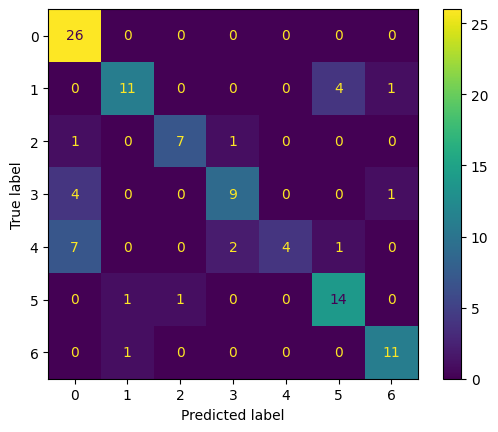


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']

Label: fear(3)
Hard cases of false negatives: ['anger(0)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']

Label: neutral(5)
Hard cases of false positives: ['boredom(1)']



In [23]:
batch_size = 8
lstm_size = 32
num_epochs = 100
train_test_val = 'paper'
normalize = False

# load the data
X_train, X_test, X_val, y_train, y_test, y_val = load_data(data_path, train_test_val=train_test_val, normalize=normalize)

# train the model
train(X_train, y_train, X_val, y_val, num_epochs=num_epochs, patience=20, batch_size=batch_size, lstm_size=lstm_size, 
      model_spec='2D_CNN_LSTM/epochs{}_batch{}_LSTM{}_{}split_norm{}'.format(num_epochs, batch_size, lstm_size, 
                                                                             train_test_val, str(normalize)))

# evaluate model with keras
loss, metric = test(X_test, y_test, model_spec='2D_CNN_LSTM/epochs{}_batch{}_LSTM{}_{}split_norm{}'.format(num_epochs, 
                                                                                                           batch_size, 
                                                                                                           lstm_size, 
                                                                                                           train_test_val, 
                                                                                                           str(normalize)))

# add own evaluation 
model = load_model('../results/models/2D_CNN_LSTM/epochs{}_batch{}_LSTM{}_{}split_norm{}.h5'.format(num_epochs, 
                                                                                                    batch_size, 
                                                                                                    lstm_size, 
                                                                                                    train_test_val, 
                                                                                                    str(normalize)))
model_eval(model, X_train, X_test, y_train, y_test, confusion=True)

### 2) Normalized data, paper split, LSTM size 32, batch size 16

There are 342 entries in the training data.
There are 107 entries in the testing data.
There are 86 entries in the validation data.
Epoch 1/100
22/22 - 32s - loss: 1.7960 - categorical_accuracy: 0.3129 - val_loss: 1.8185 - val_categorical_accuracy: 0.2674 - 32s/epoch - 1s/step
Epoch 2/100
22/22 - 26s - loss: 1.4839 - categorical_accuracy: 0.5000 - val_loss: 1.7378 - val_categorical_accuracy: 0.2558 - 26s/epoch - 1s/step
Epoch 3/100
22/22 - 28s - loss: 1.2783 - categorical_accuracy: 0.5760 - val_loss: 1.7496 - val_categorical_accuracy: 0.2907 - 28s/epoch - 1s/step
Epoch 4/100
22/22 - 28s - loss: 1.1610 - categorical_accuracy: 0.6257 - val_loss: 1.7696 - val_categorical_accuracy: 0.2326 - 28s/epoch - 1s/step
Epoch 5/100
22/22 - 25s - loss: 1.0048 - categorical_accuracy: 0.7135 - val_loss: 1.7591 - val_categorical_accuracy: 0.2093 - 25s/epoch - 1s/step
Epoch 6/100
22/22 - 28s - loss: 0.8775 - categorical_accuracy: 0.7719 - val_loss: 1.7200 - val_categorical_accuracy: 0.3488 - 28s/epoch - 

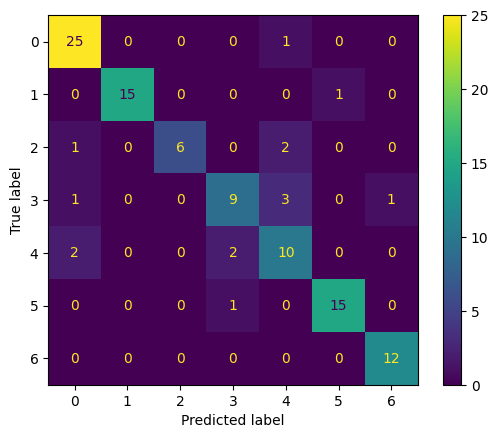


Hard cases for the model:

Label: disgust(2)
Hard cases of false negatives: ['happiness(4)']

Label: fear(3)
Hard cases of false negatives: ['happiness(4)']



In [24]:
batch_size = 16
lstm_size = 32
num_epochs = 100
train_test_val = 'paper'
normalize = True

# load the data
X_train, X_test, X_val, y_train, y_test, y_val = load_data(data_path, train_test_val=train_test_val, normalize=normalize)

# train the model
train(X_train, y_train, X_val, y_val, num_epochs=num_epochs, patience=20, batch_size=batch_size, lstm_size=lstm_size, 
      model_spec='2D_CNN_LSTM/epochs{}_batch{}_LSTM{}_{}split_norm{}'.format(num_epochs, batch_size, lstm_size, 
                                                                             train_test_val, str(normalize)))

# evaluate model with keras
loss, metric = test(X_test, y_test, model_spec='2D_CNN_LSTM/epochs{}_batch{}_LSTM{}_{}split_norm{}'.format(num_epochs, 
                                                                                                           batch_size, 
                                                                                                           lstm_size, 
                                                                                                           train_test_val, 
                                                                                                           str(normalize)))

# add own evaluation 
model = load_model('../results/models/2D_CNN_LSTM/epochs{}_batch{}_LSTM{}_{}split_norm{}.h5'.format(num_epochs, 
                                                                                                    batch_size, 
                                                                                                    lstm_size, 
                                                                                                    train_test_val, 
                                                                                                    str(normalize)))
model_eval(model, X_train, X_test, y_train, y_test, confusion=True)

### 3) Normal data, own split, LSTM size 256, batch size 16

There are 374 entries in the training data.
There are 81 entries in the testing data.
There are 80 entries in the validation data.
Epoch 1/100
24/24 - 44s - loss: 1.6778 - categorical_accuracy: 0.3743 - val_loss: 1.4253 - val_categorical_accuracy: 0.3750 - 44s/epoch - 2s/step
Epoch 2/100
24/24 - 29s - loss: 1.2992 - categorical_accuracy: 0.5214 - val_loss: 1.4373 - val_categorical_accuracy: 0.4000 - 29s/epoch - 1s/step
Epoch 3/100
24/24 - 29s - loss: 1.0062 - categorical_accuracy: 0.6444 - val_loss: 0.9877 - val_categorical_accuracy: 0.5875 - 29s/epoch - 1s/step
Epoch 4/100
24/24 - 29s - loss: 0.8771 - categorical_accuracy: 0.6658 - val_loss: 1.2246 - val_categorical_accuracy: 0.5125 - 29s/epoch - 1s/step
Epoch 5/100
24/24 - 26s - loss: 0.6929 - categorical_accuracy: 0.7754 - val_loss: 1.5257 - val_categorical_accuracy: 0.4375 - 26s/epoch - 1s/step
Epoch 6/100
24/24 - 26s - loss: 0.6091 - categorical_accuracy: 0.7888 - val_loss: 0.9164 - val_categorical_accuracy: 0.6500 - 26s/epoch - 1

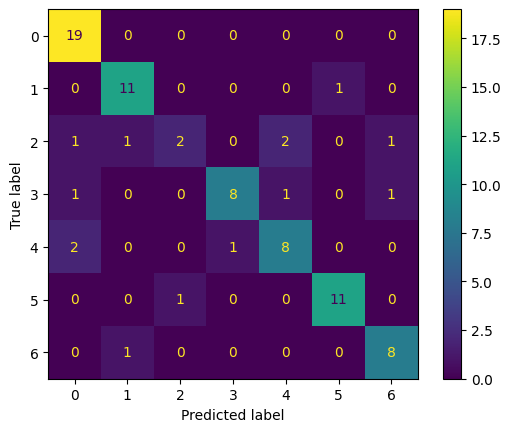


Hard cases for the model:

Label: disgust(2)
Hard cases of false negatives: ['happiness(4)']
Hard cases of false positives: ['neutral(5)']



In [25]:
batch_size = 16
lstm_size = 256
num_epochs = 100
train_test_val = 'ours'
normalize = False

# load the data
X_train, X_test, X_val, y_train, y_test, y_val = load_data(data_path, train_test_val=train_test_val, normalize=normalize)

# train the model
train(X_train, y_train, X_val, y_val, num_epochs=num_epochs, patience=20, batch_size=batch_size, lstm_size=lstm_size, 
      model_spec='2D_CNN_LSTM/epochs{}_batch{}_LSTM{}_{}split_norm{}'.format(num_epochs, batch_size, lstm_size, 
                                                                             train_test_val, str(normalize)))

# evaluate model with keras
loss, metric = test(X_test, y_test, model_spec='2D_CNN_LSTM/epochs{}_batch{}_LSTM{}_{}split_norm{}'.format(num_epochs, 
                                                                                                           batch_size, 
                                                                                                           lstm_size, 
                                                                                                           train_test_val, 

                                                                                                           str(normalize)))
# add own evaluation 
model = load_model('../results/models/2D_CNN_LSTM/epochs{}_batch{}_LSTM{}_{}split_norm{}.h5'.format(num_epochs, 
                                                                                                    batch_size, 
                                                                                                    lstm_size, 
                                                                                                    train_test_val, 
                                                                                                    str(normalize)))
model_eval(model, X_train, X_test, y_train, y_test, confusion=True)

### 4) Normalized data, own split, LSTM size 32, batch size 4

There are 374 entries in the training data.
There are 81 entries in the testing data.
There are 80 entries in the validation data.
Epoch 1/100
94/94 - 47s - loss: 1.6746 - categorical_accuracy: 0.3663 - val_loss: 1.6942 - val_categorical_accuracy: 0.3875 - 47s/epoch - 502ms/step
Epoch 2/100
94/94 - 36s - loss: 1.4121 - categorical_accuracy: 0.4893 - val_loss: 1.3874 - val_categorical_accuracy: 0.4875 - 36s/epoch - 383ms/step
Epoch 3/100
94/94 - 37s - loss: 1.2710 - categorical_accuracy: 0.5160 - val_loss: 1.4451 - val_categorical_accuracy: 0.4375 - 37s/epoch - 391ms/step
Epoch 4/100
94/94 - 37s - loss: 1.2031 - categorical_accuracy: 0.5455 - val_loss: 1.3986 - val_categorical_accuracy: 0.4375 - 37s/epoch - 389ms/step
Epoch 5/100
94/94 - 37s - loss: 1.0429 - categorical_accuracy: 0.6257 - val_loss: 1.0688 - val_categorical_accuracy: 0.6625 - 37s/epoch - 390ms/step
Epoch 6/100
94/94 - 36s - loss: 0.9259 - categorical_accuracy: 0.6791 - val_loss: 0.8769 - val_categorical_accuracy: 0.6875 

Epoch 55/100
94/94 - 36s - loss: 0.0028 - categorical_accuracy: 1.0000 - val_loss: 0.5313 - val_categorical_accuracy: 0.8125 - 36s/epoch - 388ms/step
Epoch 56/100
94/94 - 36s - loss: 0.0027 - categorical_accuracy: 1.0000 - val_loss: 0.5153 - val_categorical_accuracy: 0.8125 - 36s/epoch - 386ms/step
3/3 [==============================] - 2s 479ms/step

Evaluation: f1_score
100.00% for the train data
75.84% for the test data

Evaluation: accuracy_score
100.00% for the train data
79.01% for the test data

Evaluation: precision_score
100.00% for the train data
81.04% for the test data

Evaluation: recall_score
100.00% for the train data
74.88% for the test data

Evaluation: confusion_matrix of test predictions


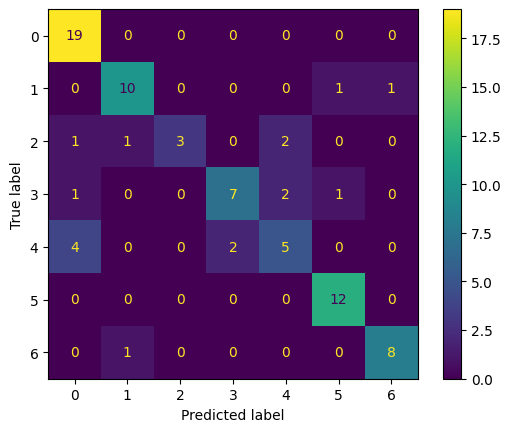


Hard cases for the model:

Label: disgust(2)
Hard cases of false negatives: ['happiness(4)']

Label: fear(3)
Hard cases of false positives: ['happiness(4)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['disgust(2)', 'fear(3)']



In [11]:
batch_size = 4
lstm_size = 32
num_epochs = 100
train_test_val = 'ours'
normalize = True

# load the data
X_train, X_test, X_val, y_train, y_test, y_val = load_data(data_path, train_test_val=train_test_val, normalize=normalize)

# train the model
train(X_train, y_train, X_val, y_val, num_epochs=num_epochs, patience=20, batch_size=batch_size, lstm_size=lstm_size, 
      model_spec='2D_CNN_LSTM/epochs{}_batch{}_LSTM{}_{}split_norm{}'.format(num_epochs, batch_size, lstm_size, 
                                                                             train_test_val, str(normalize)))

# evaluate model with keras
loss, metric = test(X_test, y_test, model_spec='2D_CNN_LSTM/epochs{}_batch{}_LSTM{}_{}split_norm{}'.format(num_epochs, 
                                                                                                           batch_size, 
                                                                                                           lstm_size, 
                                                                                                           train_test_val, 

                                                                                                           str(normalize)))
# add own evaluation 
model = load_model('../results/models/2D_CNN_LSTM/epochs{}_batch{}_LSTM{}_{}split_norm{}.h5'.format(num_epochs, 
                                                                                                    batch_size, 
                                                                                                    lstm_size, 
                                                                                                    train_test_val, 
                                                                                                    str(normalize)))
model_eval(model, X_train, X_test, y_train, y_test, confusion=True)

### 5) Best model so far but with our train-test-val split:  Normalized data, own split, LSTM size 32, batch size 16

There are 374 entries in the training data.
There are 81 entries in the testing data.
There are 80 entries in the validation data.
Epoch 1/100
24/24 - 24s - loss: 1.7614 - categorical_accuracy: 0.2941 - val_loss: 1.7575 - val_categorical_accuracy: 0.4000 - 24s/epoch - 984ms/step
Epoch 2/100
24/24 - 18s - loss: 1.4808 - categorical_accuracy: 0.4813 - val_loss: 1.6843 - val_categorical_accuracy: 0.4375 - 18s/epoch - 763ms/step
Epoch 3/100
24/24 - 20s - loss: 1.2974 - categorical_accuracy: 0.5909 - val_loss: 1.6719 - val_categorical_accuracy: 0.3750 - 20s/epoch - 814ms/step
Epoch 4/100
24/24 - 28s - loss: 1.1681 - categorical_accuracy: 0.6310 - val_loss: 1.6868 - val_categorical_accuracy: 0.3250 - 28s/epoch - 1s/step
Epoch 5/100
24/24 - 42s - loss: 1.0251 - categorical_accuracy: 0.7219 - val_loss: 1.6723 - val_categorical_accuracy: 0.2625 - 42s/epoch - 2s/step
Epoch 6/100
24/24 - 47s - loss: 0.9206 - categorical_accuracy: 0.7353 - val_loss: 1.5008 - val_categorical_accuracy: 0.4500 - 47s/

Epoch 56/100
24/24 - 33s - loss: 0.0097 - categorical_accuracy: 1.0000 - val_loss: 0.4154 - val_categorical_accuracy: 0.8750 - 33s/epoch - 1s/step
Epoch 57/100
24/24 - 34s - loss: 0.0095 - categorical_accuracy: 1.0000 - val_loss: 0.4239 - val_categorical_accuracy: 0.8625 - 34s/epoch - 1s/step
Epoch 58/100
24/24 - 34s - loss: 0.0094 - categorical_accuracy: 1.0000 - val_loss: 0.4553 - val_categorical_accuracy: 0.8750 - 34s/epoch - 1s/step
Epoch 59/100
24/24 - 33s - loss: 0.0089 - categorical_accuracy: 1.0000 - val_loss: 0.4231 - val_categorical_accuracy: 0.8750 - 33s/epoch - 1s/step
Epoch 60/100
24/24 - 32s - loss: 0.0086 - categorical_accuracy: 1.0000 - val_loss: 0.4306 - val_categorical_accuracy: 0.8750 - 32s/epoch - 1s/step
Epoch 61/100
24/24 - 32s - loss: 0.0084 - categorical_accuracy: 1.0000 - val_loss: 0.4170 - val_categorical_accuracy: 0.8875 - 32s/epoch - 1s/step
Epoch 62/100
24/24 - 29s - loss: 0.0081 - categorical_accuracy: 1.0000 - val_loss: 0.4280 - val_categorical_accuracy: 

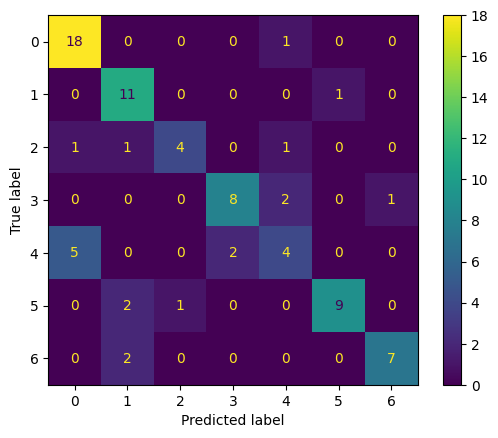


Hard cases for the model:

Label: anger(0)
Hard cases of false positives: ['happiness(4)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)']
Hard cases of false positives: ['fear(3)']

Label: sadness(6)
Hard cases of false negatives: ['boredom(1)']



In [26]:
batch_size = 16
lstm_size = 32
num_epochs = 100
train_test_val = 'ours'
normalize = True

# load the data
X_train, X_test, X_val, y_train, y_test, y_val = load_data(data_path, train_test_val=train_test_val, normalize=normalize)

# train the model
train(X_train, y_train, X_val, y_val, num_epochs=num_epochs, patience=20, batch_size=batch_size, lstm_size=lstm_size, 
      model_spec='2D_CNN_LSTM/epochs{}_batch{}_LSTM{}_{}split_norm{}'.format(num_epochs, batch_size, lstm_size, 
                                                                             train_test_val, str(normalize)))

# evaluate model with keras
loss, metric = test(X_test, y_test, model_spec='2D_CNN_LSTM/epochs{}_batch{}_LSTM{}_{}split_norm{}'.format(num_epochs, 
                                                                                                           batch_size, 
                                                                                                           lstm_size, 
                                                                                                           train_test_val, 
                                                                                                           str(normalize)))

# add own evaluation 
model = load_model('../results/models/2D_CNN_LSTM/epochs{}_batch{}_LSTM{}_{}split_norm{}.h5'.format(num_epochs, 
                                                                                                    batch_size, 
                                                                                                    lstm_size, 
                                                                                                    train_test_val, 
                                                                                                    str(normalize)))
model_eval(model, X_train, X_test, y_train, y_test, confusion=True)